# **Creating the dataset**

In [16]:
#run below code twice
#from line_profiler import LineProfiler
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.stats import percentileofscore

import numpy as np
import pandas as pd
import plotnine as gg
import torch
import torch.optim as optim
from Dataloader import TabularDataset

import higher

from torch import nn
# from acme.utils.loggers.terminal import TerminalLogger
import dataclasses
from polyadic_sampler_classification import *
#import chex
#import haiku as hk
#import jax
#import jax.numpy as jnp
#import optax
import pandas as pd
#import warnings
import gpytorch
from torch.distributions.bernoulli import Bernoulli
#warnings.filterwarnings('ignore')
from enn import *
from pipeline import *

#import pipeline_var_l2_loss
import seaborn as sns
#from dataloader import TabularDataset
#from var_l2_loss_estimator import *
#from ENN import basenet_with_learnable_epinet_and_ensemble_prior
import matplotlib.pyplot as plt

#wandb.init()

 

# Sample points: we want right clusters to have more prob of getting y=1, so sample right clusters is the optimal choice

Anchor points are sampled uniformly
Using blr model


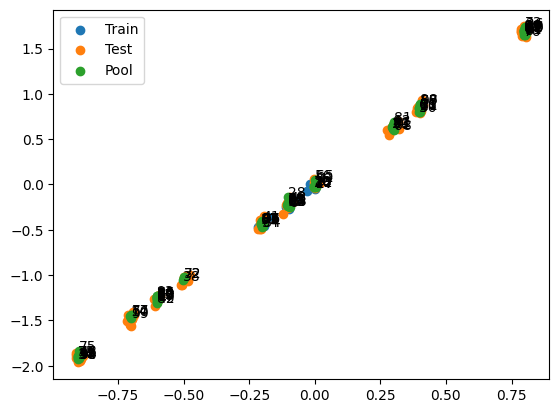

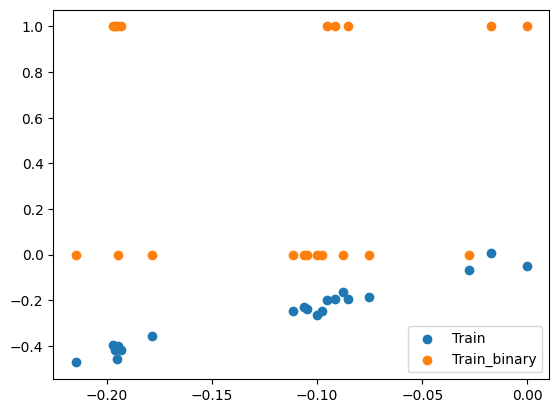

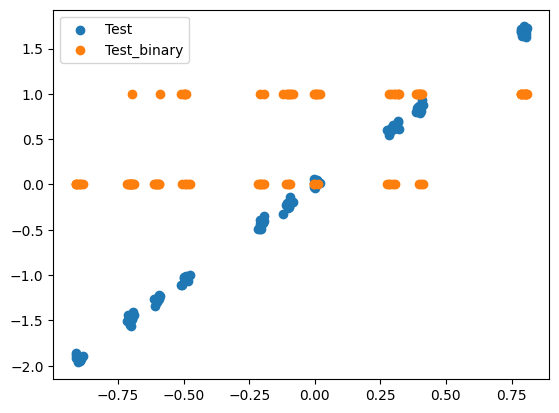

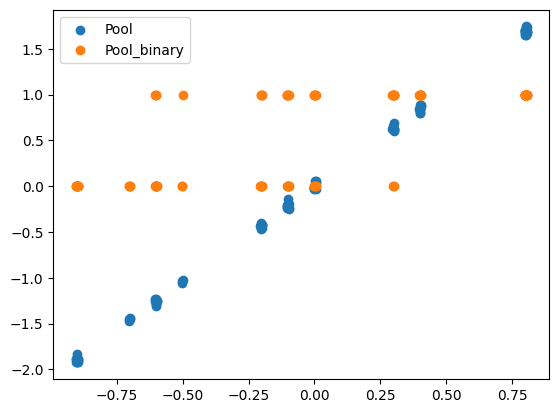

In [2]:
torch.manual_seed(12)
polyadic_sampler_config = PolyadicSamplerConfig(no_train_points = 20, no_test_points = 100, 
                                     no_pool_points = 100, model_name = 'blr', 
                                     no_anchor_points = 10, input_dim = 1, 
                                     stdev_scale = 0.1, stdev_pool_scale = 0.25,
                                     scaling_factor = None, scale_by_input_dim = None, 
                                     model = None, stdev_blr_w = 1, 
                                     stdev_blr_noise = 0.03, logits =  None, 
                                     if_logits = None, if_logits_only_pool = None, plot_folder = None, no_train_clusters = 3)
                                    
train_x, train_y, test_x, test_y, pool_x, pool_y, test_sample_idx, pool_sample_idx, train_y_binary, test_y_binary, pool_y_binary  = set_data_parameters_and_generate(polyadic_sampler_config)

In [31]:
class TabularDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
  
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):

        return self.x[idx], self.y[idx]
    
def ENN_training(x_train, y_train,model_config, enn_config, device, if_print):
    
    dataset_train = TabularDataset(x = x_train, y = y_train)
    dataloader_train = DataLoader(dataset_train, batch_size=model_config.batch_size_train, shuffle=True) 
    sample, label = dataset_train[0]
    input_feature_size = sample.shape[0]  
    
     # to_device
    ENN = basenet_with_learnable_epinet_and_ensemble_prior(input_feature_size, enn_config.basenet_hidden_sizes, model_config.n_classes, enn_config.exposed_layers, enn_config.z_dim, enn_config.learnable_epinet_hiddens, enn_config.hidden_sizes_prior, enn_config.seed_base, enn_config.seed_learnable_epinet, enn_config.seed_prior_epinet, enn_config.alpha).to(device)


    loss_fn_init = torch.nn.functional.nll_loss
    optimizer_init = optim.Adam(ENN.parameters(), lr=model_config.init_train_lr, weight_decay=model_config.init_train_weight_decay)
    # ------- seed for this training
    # ------- train ENN on initial training data  # save the state - ENN_initial_state  # define a separate optimizer for this # how to sample z's ---- separately for each batch
    # ------- they also sampled the data each time and not a dataloader - kind of a bootstrap
    #print('ENN model weights',ENN.learnable_epinet_layers[0].weight)
    enn_loss_list = []
    for i in range(model_config.n_train_init):
        ENN.train()
        for (inputs, labels) in dataloader_train:
            #inputs, labels =  inputs.to(device), labels.to(device)
            z = torch.randn(enn_config.z_dim, device=device)   #set seed for this  #set to_device for this
            optimizer_init.zero_grad()
            outputs = ENN(inputs,z)

            labels = torch.tensor(labels, dtype=torch.long, device=device)
            loss = loss_fn_init(input = outputs, target = torch.squeeze(labels))
            if if_print == 1:
                pass
                #print("ENN_init_loss:",loss)
            loss.backward()
            optimizer_init.step()

        enn_loss_list.append(float(loss.detach().to('cpu').numpy())) 
    if if_print == 0:
        plt.plot(list(range(len(enn_loss_list))),enn_loss_list)
        plt.title('ENN loss vs training iter')
        plt.show()
    
    return ENN

class Network(nn.Module):
    def __init__(self, constant_value=1.0, output_size=1):
        super(ConstantValueNetwork, self).__init__()
        # Define the constant value and output size
        #self.constant_value = nn.Parameter(torch.tensor([constant_value]*output_size), requires_grad=False)
        self.output_size = output_size

    def forward(self, x):
        # x is your input tensor. Its value is ignored in this model.
        # Return a 1-D tensor with the constant value for each item in the batch.
        batch_size = x.size(0)  # Get the batch size from the input
        return torch.sigmoid(x)
        #return self.constant_value.expand(batch_size, self.output_size)

Predictor = Network(output_size=1)


Z_dim = 1
if_print = 0

model_cfg = ModelConfig(batch_size_train = 251, batch_size_test = 500, batch_size_query = 100, temp_k_subset = 0.1, hidden_sizes_weight_NN = [50,50], meta_opt_lr = 0.01, n_classes = 2, n_epoch = 5, init_train_lr = 0.01, init_train_weight_decay = 0.00001, n_train_init = 100, meta_opt_weight_decay = 0.01)
train_config = TrainConfig(n_train_iter = 500, n_ENN_iter = 1000, ENN_opt_lr = 0.01, ENN_opt_weight_decay = 0.01, temp_var_recall = 0.3, z_dim = Z_dim,  N_iter = 20,seed_var_recall = 1 , N_iter_var_recall_est = 30)
enn_cfg = ENNConfig(basenet_hidden_sizes = [50],  exposed_layers = [True], z_dim = Z_dim, learnable_epinet_hiddens = [15], hidden_sizes_prior = [5], seed_base = 2, seed_learnable_epinet = 1, seed_prior_epinet = 0, alpha = 1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_test = TabularDataset(x = test_x, y = test_y_binary)
dataloader_test = DataLoader(dataset_test, batch_size=model_cfg.batch_size_train, shuffle=True) 

# Initial var of recall

/tmp/7424567.1.debian.q/ipykernel_32749/3867526348.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


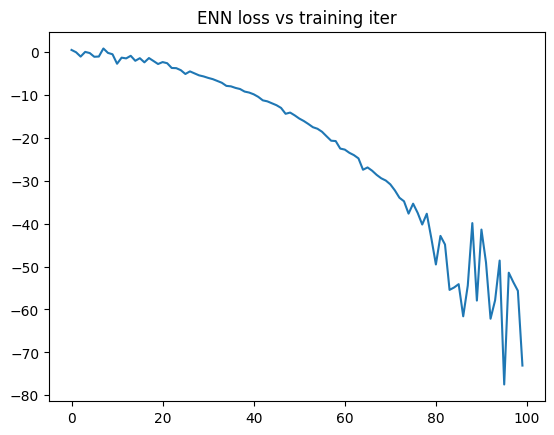

tensor(0.0273, grad_fn=<SubBackward0>)


In [53]:
ENN_trained = ENN_training(train_x, train_y_binary, model_cfg, enn_cfg, device , if_print )
meta_loss = var_recall_estimator(ENN_trained, dataloader_test, Predictor, device, para = {'tau': train_config.temp_var_recall, 'z_dim': train_config.z_dim, 'N_iter': train_config.N_iter ,'if_print':if_print, 'seed_var_recall':train_config.seed_var_recall, 'N_iter_var_recall_est':train_config.N_iter_var_recall_est})     #see where does this calculation for meta_loss happens that is it outside the innerloop_ctx or within it
print(meta_loss)

# After sample cluster centroid points with x >= 0.25 (note that these are good clusters)

/tmp/7424567.1.debian.q/ipykernel_32749/3867526348.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


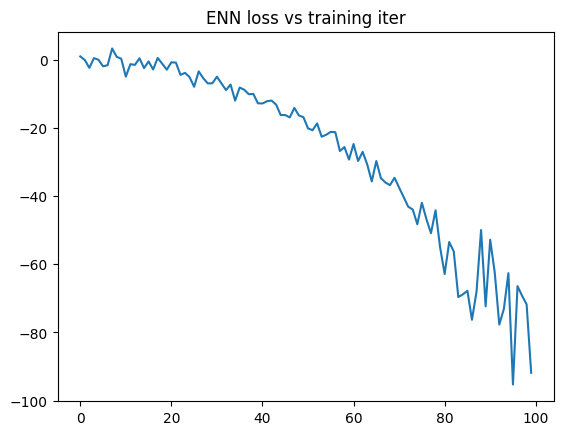

Var of recall after sampling pool data tensor(0.0174, grad_fn=<SubBackward0>)


In [83]:
new_train_y_with_pool = torch.cat((train_x, pool_x[pool_sample_idx]), 0)
new_train_x_with_pool = torch.cat((train_y_binary, pool_y_binary[pool_sample_idx]), 0)


new_pool_x = pool_x[pool_sample_idx][pool_x[pool_sample_idx] >= 0.25]
new_pool_x = torch.unsqueeze(new_pool_x,-1)
new_pool_y = pool_y_binary[pool_sample_idx][torch.squeeze(pool_x[pool_sample_idx] >= 0.25)]
new_train_y_with_pool = torch.cat((train_x, new_pool_x), 0)
new_train_x_with_pool = torch.cat((train_y_binary, new_pool_y), 0)


ENN_trained = ENN_training(new_train_y_with_pool, new_train_x_with_pool, model_cfg, enn_cfg, device , if_print )
meta_loss = var_recall_estimator(ENN_trained, dataloader_test, Predictor, device, para = {'tau': train_config.temp_var_recall, 'z_dim': train_config.z_dim, 'N_iter': train_config.N_iter ,'if_print':if_print, 'seed_var_recall':train_config.seed_var_recall, 'N_iter_var_recall_est':train_config.N_iter_var_recall_est})     #see where does this calculation for meta_loss happens that is it outside the innerloop_ctx or within it
print('Var of recall after sampling pool data',meta_loss)

